In [ ]:
from google.colab import drive
import pandas as pd
from scipy.stats.mstats import gmean
import os
!pip install dill
import dill
import yaml
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.6 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
output_path = '/content/drive/MyDrive/CMIPB_Predictions'
%cd /content/drive/MyDrive/Github/cell_crushers

%cd modelling
from utils import *
from model import *

models = yaml.safe_load(open('model_params.yaml','r'))


/content/drive/MyDrive/Github/cell_crushers
/content/drive/MyDrive/Github/cell_crushers/modelling


In [ ]:
def load_test_data():
  test_data = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/IntegratedTestData.tsv',sep='\t',index_col=0)
  test_data['biological_sex'] = test_data['biological_sex'].map(lambda x:1 if x=='Female' else 0)
  test_data['infancy_vac'] = test_data['infancy_vac'].map(lambda x:1 if x=='aP' else 0)
  return test_data

def load_train_data(task, file):
  features = pd.read_pickle(os.path.join('/content/drive/MyDrive/CMIPB_Files/', task, 'AllFeatures.p'))
  for x in features:
    features[x] = list(features[x])
  return pd.read_csv(os.path.join('/content/drive/MyDrive/CMIPB_Files/', task, file), sep = '\t'), features

def reconcile_features(test_data, training_data):
  for x in [p for p in training_data if 'GEX' in p]:
    if x not in test_data.columns:
      test_data[x] = test_data[x.split(',')].apply(gmean,axis=1)
  return test_data

def batch_normalize(X, features):
  categorical_features = np.array(['biological_sex','infancy_vac'])
  normalize = np.where(~np.isin(features, categorical_features))[0]
  X[:, normalize] = StandardScaler().fit_transform(X[:, normalize])
  return X

def reduce_dimensions(X: np.array, y: np.array, features: np.array, features_to_change: np.array, n_components: int, reducer, trained: bool = False, supervised: bool = True, interpretable: bool = False):
    features = np.array(features)
    features_to_change = np.array(features_to_change)
    feature_idxs = np.where(np.isin(features, features_to_change))[0]
    features_to_keep = np.where(~np.isin(features, features_to_change))[0]
    print(n_components, len(features), len(features_to_change), X.shape[0])
    if not trained:
      reduction = reducer(n_components = n_components)
      if supervised:
        X_trans = reduction.fit(X[:, feature_idxs], y).transform(X[:, feature_idxs])
      else:
        X_trans = reduction.fit(X[:, feature_idxs]).transform(X[:, feature_idxs])
    else:
      reduction = reducer
      X_trans = reduction.transform(X[:, feature_idxs])
    X_new = np.hstack([X_trans, X[:, features_to_keep]])
    if interpretable:
        old_feature_names = dict((f'Feat{k}', p) for k, p in enumerate(features))
        new_feature_order = [old_feature_names[p.split(':')[0]]+':'+old_feature_names[p.split(':')[1]] for p in X_trans.columns]
        new_feature_order = new_feature_order + list(features[features_to_keep])
    new_feature_order = [f'NewFeat{p}' for p in range(n_components)] + list(features[features_to_keep])
    return X_new, reduction, new_feature_order

In [ ]:
def ranks(arr):
    sorted_indices = np.argsort(arr)
    rank_array = np.empty_like(sorted_indices)
    rank_array[sorted_indices] = np.arange(len(arr))[::-1]
    return rank_array

In [ ]:
output_path = '/content/drive/MyDrive/Final'
os.mkdir(output_path)

In [ ]:
values = {'Monocytes':
          {'top_models':{'RegularCV':'XGBoost_Residual_0.1_24_1_L2_1_2_uncorrelated_0.7_PCA_Genes_10_RegularCV',
              'CrossDatasetCV':'GradientBoost_Residuals_log2_5_squared_error_0.9_uncorrelated_0.8_NoTransform_CrossDataset',
              'RegularCV_FC':'ElasticNet_Residuals_0.01_filtered_genes_PCA_Genes_30_RegularCV',
              'CrossDatasetCV_FC':'Ridge_Residuals_1_uncorrelated_0.9_PCA_Genes_10_CrossDataset'},
               'model_params': {'XGBoost_Residual_0.1_24_1_L2_1_2_uncorrelated_0.7_PCA_Genes_10_RegularCV':models['XGBoost_Residual_0.1_24_1_L2_1_2'],
                'GradientBoost_Residuals_log2_5_squared_error_0.9_uncorrelated_0.8_NoTransform_CrossDataset':models['GradientBoost_Residuals_log2_5_squared_error_0.9'],
                'ElasticNet_Residuals_0.01_filtered_genes_PCA_Genes_30_RegularCV':models['ElasticNet_Residuals_0.01'],
                'Ridge_Residuals_1_uncorrelated_0.9_PCA_Genes_10_CrossDataset':models['Ridge_Residuals_1']},
           'baseline':'Cellfrequency_Monocytes',
           'dirname':'mono_task'},
          'CCL3':{'top_models': {'RegularCV':'GradientBoost_Residuals_sqrt_1000_absolute_error_1_filtered_genes_NoTransform_RegularCV',
              'CrossDatasetCV':'GradientBoost_Residuals_sqrt_1000_squared_error_0.9_uncorrelated_0.7_NoTransform_CrossDataset',
              'RegularCV_FC':'XGBoost_Residual_0.1_24_0.8_L2_4_15_filtered_genes_NoTransform_RegularCV',
              'CrossDatasetCV_FC':'GradientBoost_Residuals_None_10_absolute_error_1_genes_PCA_Genes_10_CrossDataset'},

               'model_params':{'GradientBoost_Residuals_sqrt_1000_absolute_error_1_filtered_genes_NoTransform_RegularCV':models['GradientBoost_Residuals_sqrt_1000_absolute_error_1'],
                'GradientBoost_Residuals_sqrt_1000_squared_error_0.9_uncorrelated_0.7_NoTransform_CrossDataset':models['GradientBoost_Residuals_sqrt_1000_squared_error_0.9'],
                'XGBoost_Residual_0.1_24_0.8_L2_4_15_filtered_genes_NoTransform_RegularCV':models['XGBoost_Residual_0.1_24_0.8_L2_4_15'],
                'GradientBoost_Residuals_None_10_absolute_error_1_genes_PCA_Genes_10_CrossDataset':models['GradientBoost_Residuals_None_10_absolute_error_1']},
                'baseline':'Cytokine_CCL3',
                'dirname':'ccl3_task'},
          'Ig':{'top_models': {'RegularCV':'ElasticNet_Residuals_0.05_uncorrelated_0.7_PCA_Genes_30_RegularCV',
              'CrossDatasetCV':'GradientBoost_Residuals_None_1000_absolute_error_0.8_uncorrelated_0.8_PCA_Genes_10_CrossDataset',
              'RegularCV_FC':'GradientBoost_None_1000_absolute_error_0.8_uncorrelated_0.7_PCA_Genes_30_RegularCV',
              'CrossDatasetCV_FC':'XGBoost_0.5_6_1_L2_1_10_uncorrelated_0.9_NoTransform_CrossDataset'},
               'model_params':{'ElasticNet_Residuals_0.05_uncorrelated_0.7_PCA_Genes_30_RegularCV':models['ElasticNet_Residuals_0.05'],
                'GradientBoost_Residuals_None_1000_absolute_error_0.8_uncorrelated_0.8_PCA_Genes_10_CrossDataset':models['GradientBoost_Residuals_None_1000_absolute_error_0.8'],
                'GradientBoost_None_1000_absolute_error_0.8_uncorrelated_0.7_PCA_Genes_30_RegularCV':models['GradientBoost_None_1000_absolute_error_0.8'],
                'XGBoost_0.5_6_1_L2_1_10_uncorrelated_0.9_NoTransform_CrossDataset':models['XGBoost_0.5_6_1_L2_1_10']},
              'baseline':'Titre_IgG_PT',
              'dirname':'ig_task'}}


In [ ]:


for task in values:
  all_predictions = {}
  top_models = values[task]['top_models']
  model_params = values[task]['model_params']
  for model in top_models:
    target = 'Target' if 'FC' not in model else 'Target_FC'
    test_data = load_test_data()
    baseline = values[task]['baseline']
    model_name = top_models[model]
    data_file = 'IntegratedData_normalized.tsv' if 'uncorrelated' not in model_name else 'feature_analysis/CorrelationFiltered0.8.tsv' if \
              'correlated_0.8' in model_name else 'feature_analysis/CorrelationFiltered0.9.tsv' if 'correlated_0.9' in model_name \
              else 'feature_analysis/CorrelationFiltered0.7.tsv'
    training_data, features = load_train_data(values[task]['dirname'], data_file)
    if model_type == 'Ig':
      training_data['Target'] = training_data[target].map(np.log2)
      training_data[baseline] = training_data[baseline].map(np.log2)
      test_data[baseline] = test_data[baseline].map(np.log2)
    test_data = reconcile_features(test_data, training_data)

    if 'filtered_genes' in model_name:
      features = features['cell_freq']+features['cytokine']+features['filtered_genes']+features['demographic']
    elif 'correlat' in model_name:
      features = features['cell_freq']+features['cytokine']+[p for p in training_data if 'GEX' in p]+features['demographic']
    elif 'genes' in model_name:
      features = features['cell_freq']+features['cytokine']+features['genes']+features['demographic']
    if 'PCA' in model_name:
      n_components = 10 if 'PCA_Genes_10' in model_name else 30 if 'PCA_Genes_30' in model_name else 50
    training_data = training_data.dropna(subset=features+['Target'])
    for column in features:
      test_data[column] = test_data[column].fillna(test_data[column].median())
    train_X = batch_normalize(training_data[features].values, features)
    train_Y = StandardScaler().fit_transform(training_data['Target'].values.reshape(-1,1))
    test_X = batch_normalize(test_data[features].values, features)
    if 'PCA' in model_name:
      train_X, reducer, _ = reduce_dimensions(train_X, '', features, [p for p in features if 'GEX' in p], reducer = PCA, trained = False, n_components = n_components)
      test_X, _, _ = reduce_dimensions(test_X, '', features, [p for p in features if 'GEX' in p], reducer = reducer, trained = True, n_components = n_components)
      print(f'Doing PCA: {model}, {n_components}')
      dill.dump(reducer, open(os.path.join(output_path, f'{task}_{model}_PCA.p'), 'wb'))
    model_ = model_dictionary[model_params[top_models[model]]['model_type']](**model_params[top_models[model]]['fit'])
    model_.fit(train_X, train_Y.ravel())
    prediction = model_.predict(train_X)
    training_data['Pred'] = prediction
    output = model_.predict(test_X)
    test_data['Prediction'] = output
    test_data['Rank'] = ranks(test_data["Prediction"])+1
    prediction = model_.predict(train_X)
    print(spearmanr(prediction, train_Y.ravel()))
    output = model_.predict(test_X)
    test_data['Prediction'] = output
    test_data['Rank'] = ranks(test_data["Prediction"])+1
    all_predictions[model] = dict(test_data[['subject_id','Rank']].values)
    dill.dump(model_, open(os.path.join(output_path, f'{task}_{model}.joblib'), 'wb'))
  pd.DataFrame(all_predictions).to_csv(os.path.join(output_path, f'{task}_Prediction.csv'))

10 39 20 49
10 39 20 21
Doing PCA: RegularCV, 10
SignificanceResult(statistic=0.8607362435515972, pvalue=2.205214499879972e-15)


<ipython-input-33-48b84ae80832>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Pred'] = prediction


SignificanceResult(statistic=0.9031352843572508, pvalue=7.0514046649076375e-19)
30 65 46 49
30 65 46 21
Doing PCA: RegularCV_FC, 30
SignificanceResult(statistic=0.9875251922905253, pvalue=2.1674584665492768e-39)


<ipython-input-33-48b84ae80832>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Pred'] = prediction


10 51 32 49
10 51 32 21
Doing PCA: CrossDatasetCV_FC, 10
SignificanceResult(statistic=0.8879818365602844, pvalue=1.807412612006014e-17)
SignificanceResult(statistic=0.9999999999999999, pvalue=0.0)
SignificanceResult(statistic=0.9999999999999999, pvalue=0.0)
SignificanceResult(statistic=0.9330612244897959, pvalue=1.6694077499560843e-22)
10 122 103 49
10 122 103 21
Doing PCA: CrossDatasetCV_FC, 10
SignificanceResult(statistic=0.8742857142857142, pvalue=2.3249605007572143e-16)
30 58 46 46
30 58 46 21
Doing PCA: RegularCV, 30
SignificanceResult(statistic=0.8670366944187481, pvalue=6.669682042780442e-15)


<ipython-input-33-48b84ae80832>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Pred'] = prediction


10 81 69 46
10 81 69 21
Doing PCA: CrossDatasetCV, 10
SignificanceResult(statistic=1.0, pvalue=0.0)
30 58 46 46
30 58 46 21
Doing PCA: RegularCV_FC, 30
SignificanceResult(statistic=1.0, pvalue=0.0)
SignificanceResult(statistic=0.9997533148319457, pvalue=2.1206892833690135e-74)


In [ ]:
model = dill.load(open(os.path.join(output_path, f'Monocytes_RegularCV.joblib'), 'rb'))
pca = dill.load(open(os.path.join(output_path, f'Monocytes_RegularCV_PCA.p'), 'rb'))

In [ ]:
# %pip install shap
# import shap


data, total_features = load_train_data('mono_task','feature_analysis/CorrelationFiltered0.7.tsv')
features = total_features['cell_freq']+total_features['cytokine']+[p for p in data if 'GEX' in p]+total_features['demographic']
X = data[features].dropna().values
X = batch_normalize(X, features = np.array(features))
df = pd.DataFrame(X)
df.columns = features
X, reducer, _ = reduce_dimensions(X, '', features, [p for p in features if 'GEX' in p], reducer = pca, trained = True, n_components = 10)
new_features = _
explainer = shap.TreeExplainer(new_xgb_regressor)
out = explainer.shap_values(X[:, :-1], data.dropna(subset=features)['Target'])

10 39 20 49


In [ ]:
shap.initjs()
shap.force_plot(expected_value, out[6], feature_names=new_features[:-1])

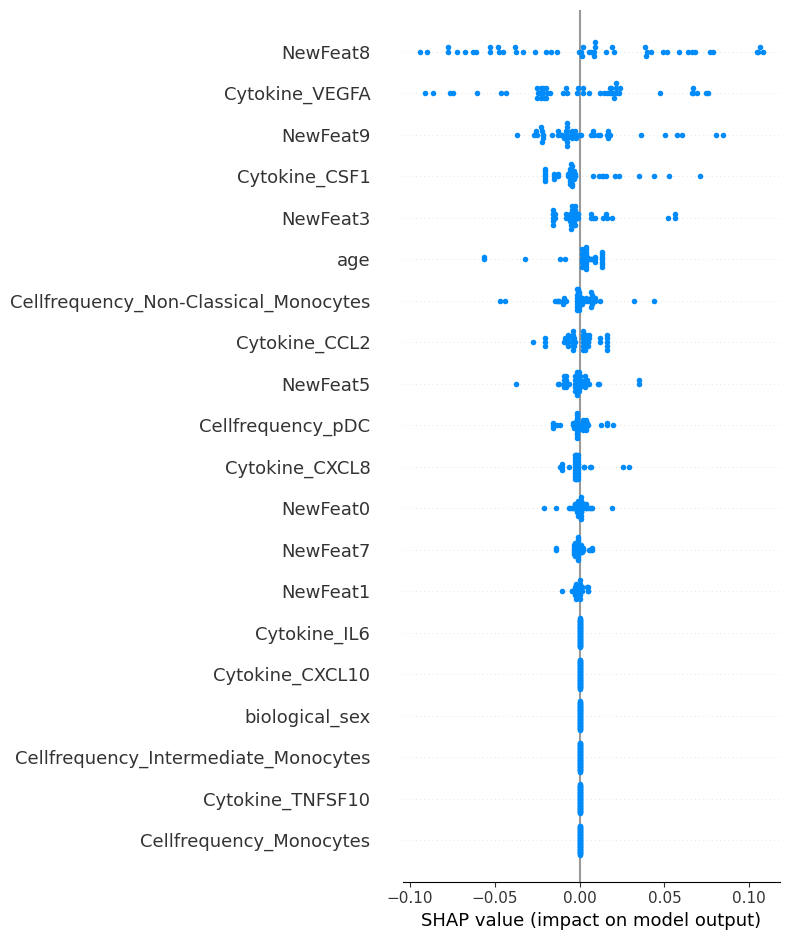

In [ ]:
shap.summary_plot(out, feature_names = new_features[:-1])

In [ ]:
model.save_model('model.json')

# Load the model into a new instance
new_xgb_regressor = XGBRegressor()
new_xgb_regressor.load_model('model.json')

In [ ]:
def write_final_prediction_file(test_data, output_path, paths = ['Ig','Monocytes','CCL3'], type = "RegularCV"):
  for value in paths:
    x = pd.read_csv(os.path.join(output_path, f'{value}_Prediction.csv'), index_col = 0)
    abs_value = dict(x[type])
    fc_value = dict(x[f'{type}_FC'])
    print(x)
    test_data[f'Prediction_{value}'] = test_data['subject_id'].map(abs_value)
    test_data[f'Prediction_{value}_FC'] = test_data['subject_id'].map(fc_value)
  return test_data[['subject_id','age','biological_sex','infancy_vac','Prediction_Ig','Prediction_Ig_FC','Prediction_Monocytes','Prediction_Monocytes_FC','Prediction_CCL3','Prediction_CCL3_FC']]
eve = write_final_prediction_file(test_data, output_path)
sloan = write_final_prediction_file(test_data, output_path)